# Baseline XGBoost — Fenêtres glissantes

**Approche** : chaque échantillon correspond à une semaine.
- **Entrée (X)** : les features des 5 jours de la semaine N, aplaties en un vecteur.
- **Sortie (y)** : les valeurs `GLOBAL` (présence) des 5 jours de la semaine N+1.
- **Évaluation** : prédiction de la dernière semaine du dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

warnings.filterwarnings('ignore')
np.random.seed(42)

## 1. Chargement et préparation des données

In [3]:
df = pd.read_csv('../data/df_venues_final.csv', sep=';')

# Convertir les colonnes booléennes en entiers
bool_cols = ['jour_jeudi', 'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_vendredi']
for col in bool_cols:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

# Numéro de jour dans la semaine (0=lundi … 4=vendredi) pour le tri
def get_day_num(row):
    if row['jour_lundi']:    return 0
    if row['jour_mardi']:    return 1
    if row['jour_mercredi']: return 2
    if row['jour_jeudi']:    return 3
    if row['jour_vendredi']: return 4
    return -1

df['day_num'] = df.apply(get_day_num, axis=1)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

print(f'Dimensions : {df.shape}')
print(f'Colonnes   : {list(df.columns)}')
df.head(10)

Dimensions : (250, 18)
Colonnes   : ['GLOBAL', 'jour_ferie.', 'pont.conge.', 'holiday', 'Semaine', 'Annee', 'Temp', 'pluie', 'autre', 'Greve_nationale', 'prof_nationale', 'Total_reservations', 'jour_jeudi', 'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_vendredi', 'day_num']


,GLOBAL,jour_ferie.,pont.conge.,holiday,Semaine,Annee,Temp,pluie,autre,Greve_nationale,prof_nationale,Total_reservations,jour_jeudi,jour_lundi,jour_mardi,jour_mercredi,jour_vendredi,day_num
0,240,0,0,0,36,2022,20,3.1,1,0,0,203,0,1,0,0,0,0
1,542,0,0,0,36,2022,17,0.4,0,0,0,257,0,0,1,0,0,1
2,657,0,0,0,36,2022,17,0.5,1,0,0,220,0,0,0,1,0,2
3,607,0,0,0,36,2022,15,0.4,1,0,0,181,1,0,0,0,0,3
4,461,0,0,0,36,2022,15,0.4,1,0,0,149,0,0,0,0,1,4
5,612,0,0,0,37,2022,16,0.0,0,0,0,208,0,1,0,0,0,0
6,682,0,0,0,37,2022,22,0.1,0,0,0,271,0,0,1,0,0,1
7,649,0,0,0,37,2022,18,3.5,0,0,0,241,0,0,0,1,0,2
8,653,0,0,0,37,2022,18,0.3,0,0,0,258,1,0,0,0,0,3
9,422,0,0,0,37,2022,14,0.0,0,0,0,134,0,0,0,0,1,4


## 2. Construction des fenêtres glissantes (semaine N → semaine N+1)

In [4]:
# Colonnes utilisées comme features (toutes sauf GLOBAL et day_num)
feature_cols = [c for c in df.columns if c not in ['GLOBAL', 'day_num']]

# Liste des semaines dans l'ordre chronologique
week_groups = df.groupby(['Annee', 'Semaine'])
week_keys   = sorted(week_groups.groups.keys())  # [(2022,36), (2022,37), ...]

print(f'Nombre de semaines : {len(week_keys)}')
print(f'Première semaine : {week_keys[0]}  |  Dernière semaine : {week_keys[-1]}')

X_list, y_list, meta = [], [], []

for i in range(len(week_keys) - 1):
    w_cur  = week_groups.get_group(week_keys[i]).sort_values('day_num')
    w_next = week_groups.get_group(week_keys[i + 1]).sort_values('day_num')

    # Ignorer les semaines incomplètes
    if len(w_cur) != 5 or len(w_next) != 5:
        continue

    # Aplatissement des features de la semaine courante
    x = w_cur[feature_cols].values.flatten()
    y = w_next['GLOBAL'].values  # 5 valeurs cibles

    X_list.append(x)
    y_list.append(y)
    meta.append(week_keys[i + 1])  # semaine prédite

X    = np.array(X_list, dtype=float)
y    = np.array(y_list, dtype=float)
meta = np.array(meta)

# Noms de features lisibles : colonne_jour
days_short   = ['lun', 'mar', 'mer', 'jeu', 'ven']
feature_names = [f'{col}_{d}' for d in days_short for col in feature_cols]

print(f'\nX : {X.shape}  |  y : {y.shape}')
print(f'Nombre de features : {X.shape[1]}')

Nombre de semaines : 50
Première semaine : (2022, 36)  |  Dernière semaine : (2023, 39)

X : (49, 80)  |  y : (49, 5)
Nombre de features : 80


## 3. Découpage train / test

Le jeu de test correspond à la **dernière semaine** du dataset.  
Toutes les semaines précédentes constituent le jeu d'entraînement.

In [5]:
X_train, X_test = X[:-1], X[[-1]]
y_train, y_test = y[:-1], y[[-1]]
last_week = meta[-1]

print(f'Entraînement : {X_train.shape[0]} semaines')
print(f'Test         : {X_test.shape[0]} semaine — Annee={last_week[0]}, Semaine={last_week[1]}')

Entraînement : 48 semaines
Test         : 1 semaine — Annee=2023, Semaine=39


## 4. Entraînement du modèle XGBoost

In [6]:
xgb_base = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0,
)

# MultiOutputRegressor entraîne un modèle indépendant par jour cible
model = MultiOutputRegressor(xgb_base)
model.fit(X_train, y_train)

# Erreur sur l'ensemble d'entraînement (référence)
y_train_pred = model.predict(X_train)
train_mae  = mean_absolute_error(y_train, y_train_pred)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
print(f'Train  — MAE : {train_mae:.1f}  |  RMSE : {train_rmse:.1f}')

Train  — MAE : 2.2  |  RMSE : 3.1


## 5. Évaluation sur la dernière semaine

In [7]:
y_pred = model.predict(X_test)

day_labels = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']

print(f'Résultats — Semaine {last_week[1]}, {last_week[0]}')
print(f'{"Jour":<12} {"Réel":>8} {"Prédit":>8} {"Erreur abs":>12}')
print('-' * 42)
for i, day in enumerate(day_labels):
    actual = y_test[0][i]
    pred   = y_pred[0][i]
    print(f'{day:<12} {actual:>8.0f} {pred:>8.0f} {abs(actual - pred):>12.0f}')

test_mae  = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f'\nTest   — MAE : {test_mae:.1f}  |  RMSE : {test_rmse:.1f}')

Résultats — Semaine 39, 2023
Jour             Réel   Prédit   Erreur abs
------------------------------------------
Lundi             624      607           17
Mardi             713      678           35
Mercredi          623      653           30
Jeudi             659      629           30
Vendredi          408      472           64

Test   — MAE : 35.2  |  RMSE : 35.2


## 6. Visualisation

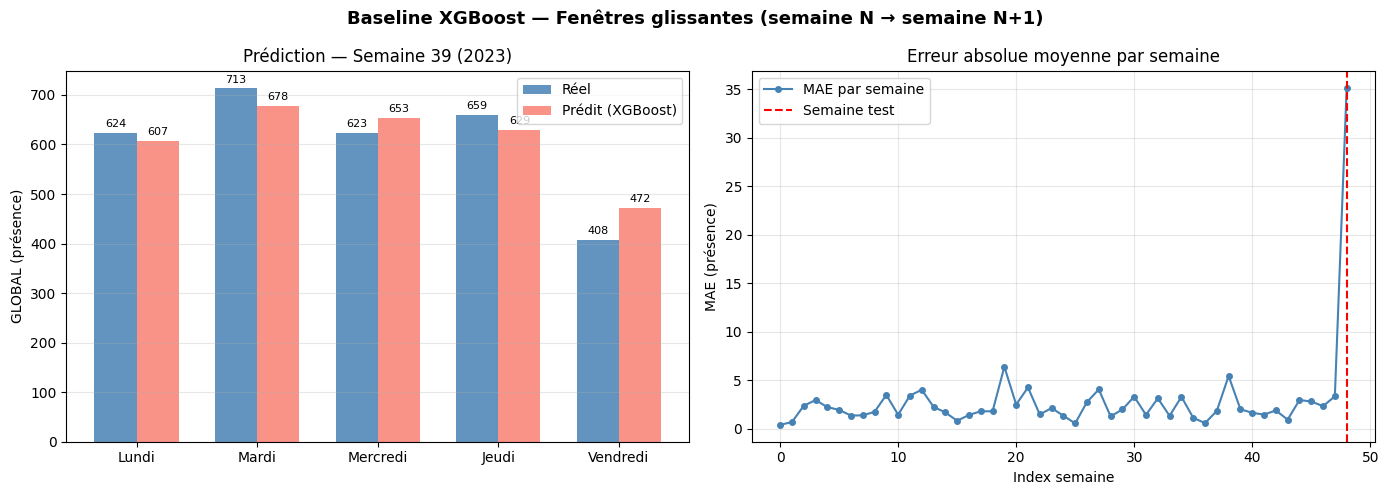

Figure sauvegardée dans img/baseline_xgboost.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Graphique 1 : barres réel vs prédit ---
ax = axes[0]
x_pos = np.arange(len(day_labels))
w = 0.35

bars_real = ax.bar(x_pos - w/2, y_test[0], w, label='Réel',             color='steelblue', alpha=0.85)
bars_pred = ax.bar(x_pos + w/2, y_pred[0], w, label='Prédit (XGBoost)', color='salmon',    alpha=0.85)

for bar in [*bars_real, *bars_pred]:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 8,
            f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=8)

ax.set_xticks(x_pos)
ax.set_xticklabels(day_labels)
ax.set_ylabel('GLOBAL (présence)')
ax.set_title(f'Prédiction — Semaine {last_week[1]} ({last_week[0]})')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# --- Graphique 2 : MAE par semaine sur tout l'historique ---
ax2 = axes[1]
all_pred = model.predict(X)
all_mae  = np.mean(np.abs(y - all_pred), axis=1)

ax2.plot(range(len(all_mae)), all_mae, marker='o', markersize=4,
         color='steelblue', label='MAE par semaine')
ax2.axvline(len(all_mae) - 1, color='red', linestyle='--', label='Semaine test')
ax2.set_xlabel('Index semaine')
ax2.set_ylabel('MAE (présence)')
ax2.set_title('Erreur absolue moyenne par semaine')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle('Baseline XGBoost — Fenêtres glissantes (semaine N → semaine N+1)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../img/baseline_xgboost.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure sauvegardée dans img/baseline_xgboost.png')

## 7. Importance des features (première journée cible)

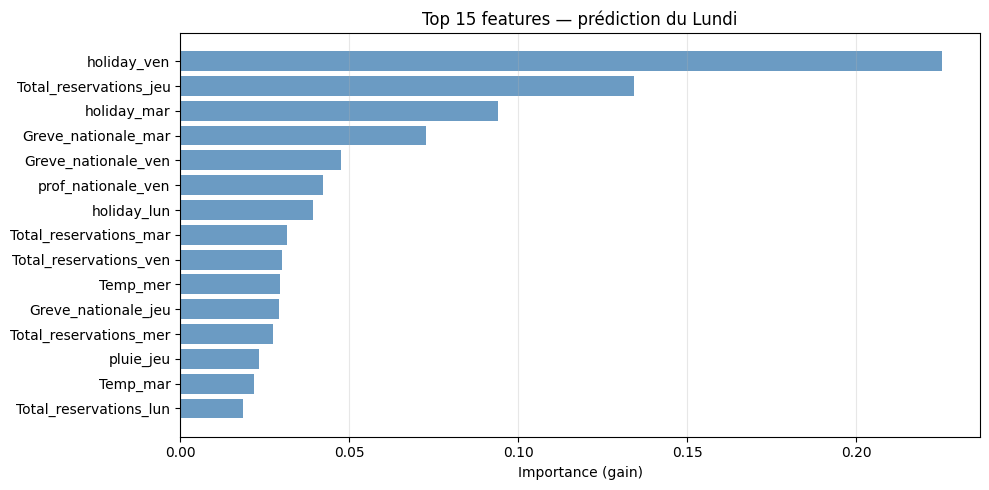

In [9]:
# Importance pour le modèle prédit le lundi (estimateur 0)
importances = model.estimators_[0].feature_importances_
top_n = 15

sorted_idx = np.argsort(importances)[::-1][:top_n]
top_names  = [feature_names[i] for i in sorted_idx]
top_vals   = importances[sorted_idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(top_names[::-1], top_vals[::-1], color='steelblue', alpha=0.8)
ax.set_xlabel('Importance (gain)')
ax.set_title(f'Top {top_n} features — prédiction du Lundi')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()